<a href="https://colab.research.google.com/github/berberberk/apms-fs-2024/blob/main/APMS_CoxBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)


normal_data = np.random.normal(loc=50, scale=10, size=100)

outlier_data = np.random.normal(loc=30, scale=5, size=95)
outlier_data = np.append(outlier_data, [80, 85, 90, 95, 100])

r_skewed_data = np.random.exponential(scale=10, size=100)
l_skewed_data = -np.random.exponential(scale=10, size=100) + 50

multimodal_data = np.concatenate([
    np.random.normal(loc=35, scale=5, size=50),  # First peak
    np.random.normal(loc=55, scale=5, size=50)  # Second peak
])

complex_data = np.concatenate([
    np.random.exponential(scale=8, size=70),
    np.random.normal(loc=50, scale=5, size=25),
    [100, 110, 120, 130, 140]  # Outliers
])

noise = np.random.normal(0, 3, size=100)
data = pd.DataFrame({
    "Normal": normal_data,
    "Outliers": outlier_data,
    "Right Skewed": r_skewed_data + noise,
    "Multimodal": multimodal_data,
    "Complex": complex_data,
    "Left Skewed": l_skewed_data + noise
})

coefficients = [0.1, 0, 0, 0, 0]
noise = np.random.normal(0, 3, size=100)
data["Response"] = (
    coefficients[0] * data["Normal"] +
    coefficients[1] * data["Outliers"] +
    coefficients[2] * data["Right Skewed"] +
    coefficients[3] * data["Multimodal"] +
    coefficients[4] * data["Complex"] +
    noise
)

data.head()


,Normal,Outliers,Right Skewed,Multimodal,Complex,Left Skewed,Response
0,54.967142,22.923146,5.859883,36.926587,1.848738,19.246205,7.966226
1,48.617357,27.896773,-0.131385,36.613593,3.623849,40.278509,5.081690
2,56.476885,28.286427,12.564186,30.863845,5.600041,48.105872,1.777806
3,65.230299,25.988614,44.375022,37.596733,9.379659,37.961053,2.637794
4,47.658466,29.193571,4.016282,42.663695,0.320846,46.377517,3.758493


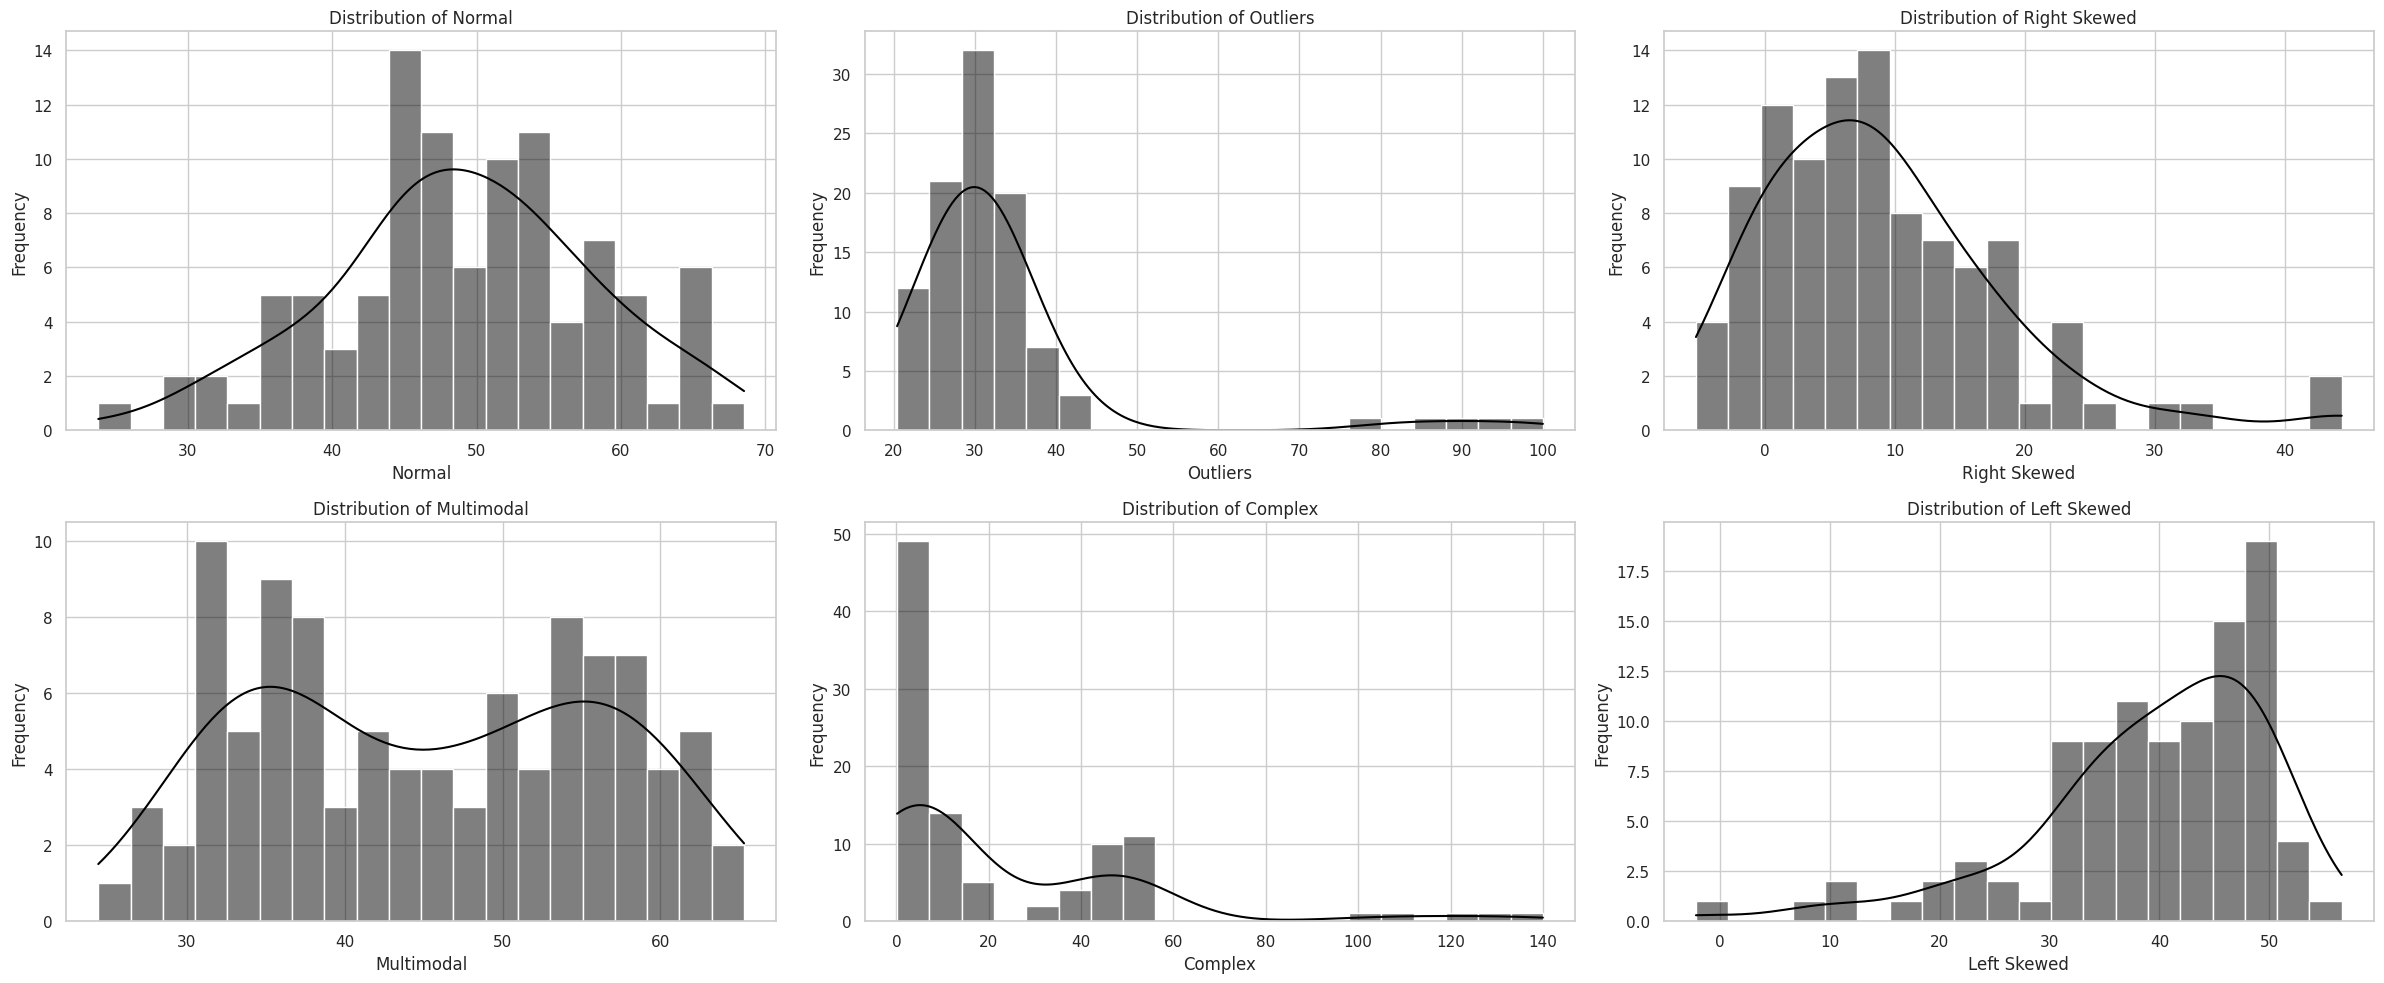

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(24, 10))

features = ["Normal", "Outliers", "Right Skewed", "Multimodal", "Complex", "Left Skewed"]
for i, feature in enumerate(features):
    ax = axes.flat[i]
    sns.histplot(data[feature], kde=True, bins=20, ax=ax, alpha=0.5, color="black")
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


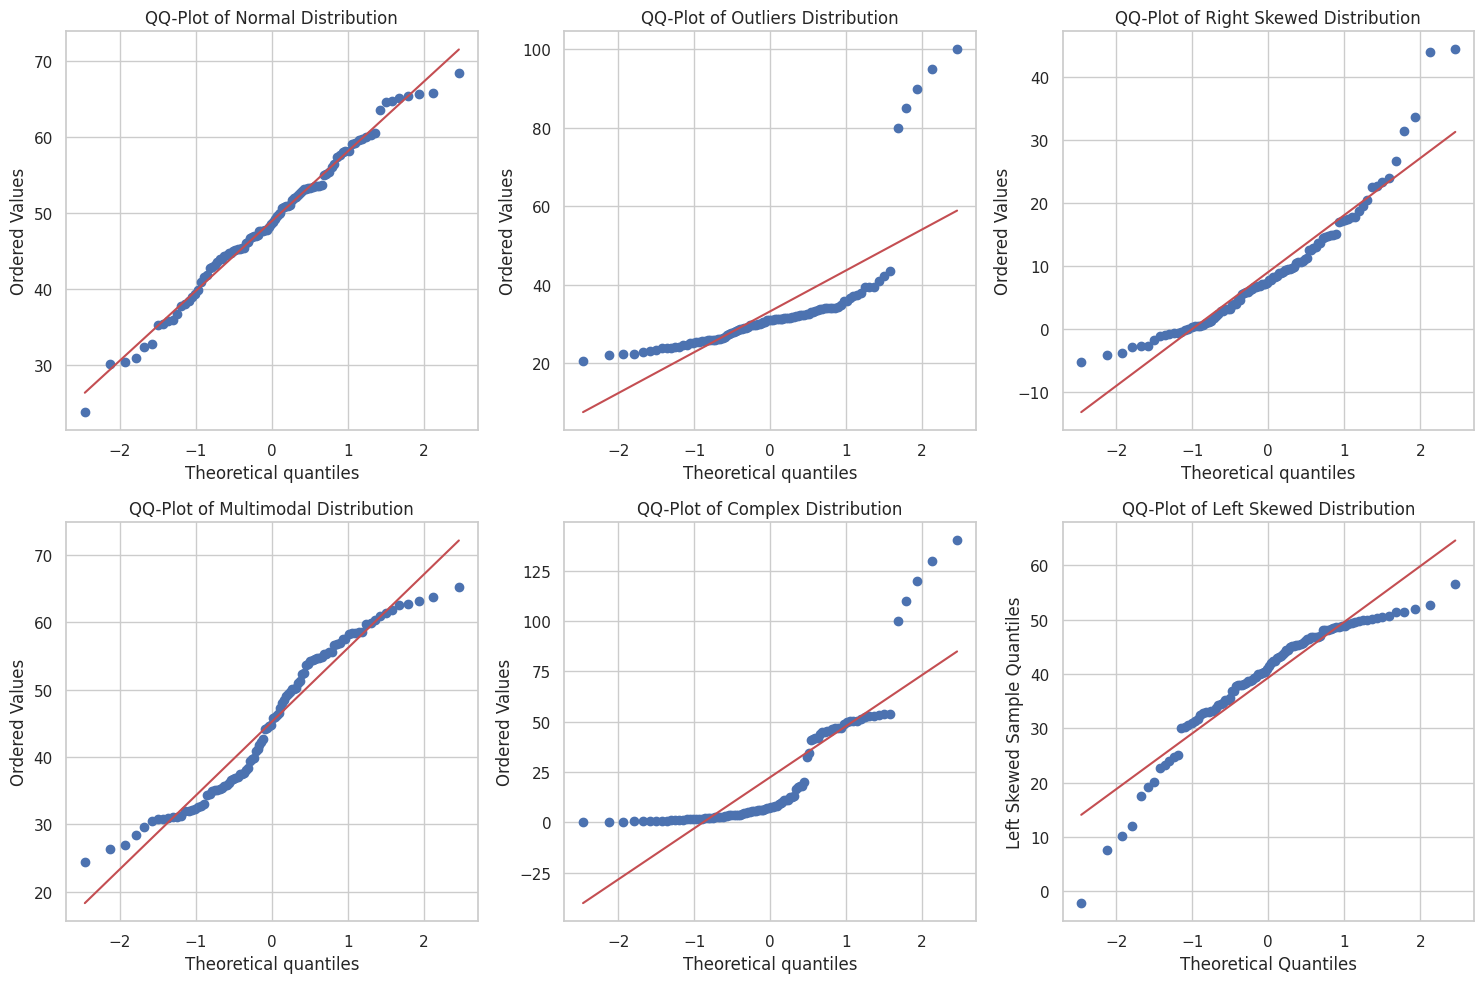

In [ ]:
import statsmodels.api as sm

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ["Normal", "Outliers", "Right Skewed", "Multimodal", "Complex", "Left Skewed"]
for i, feature in enumerate(features):
    ax = axes.flat[i]
    #sm.qqplot(data[feature], line='s', fit=True)
    stats.probplot(data[feature], dist="norm", plot=ax, fit=True)
    plt.title("")
    ax.set_title(f"QQ-Plot of {feature} Distribution")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel(f"{feature} Sample Quantiles")

plt.tight_layout()
plt.show()

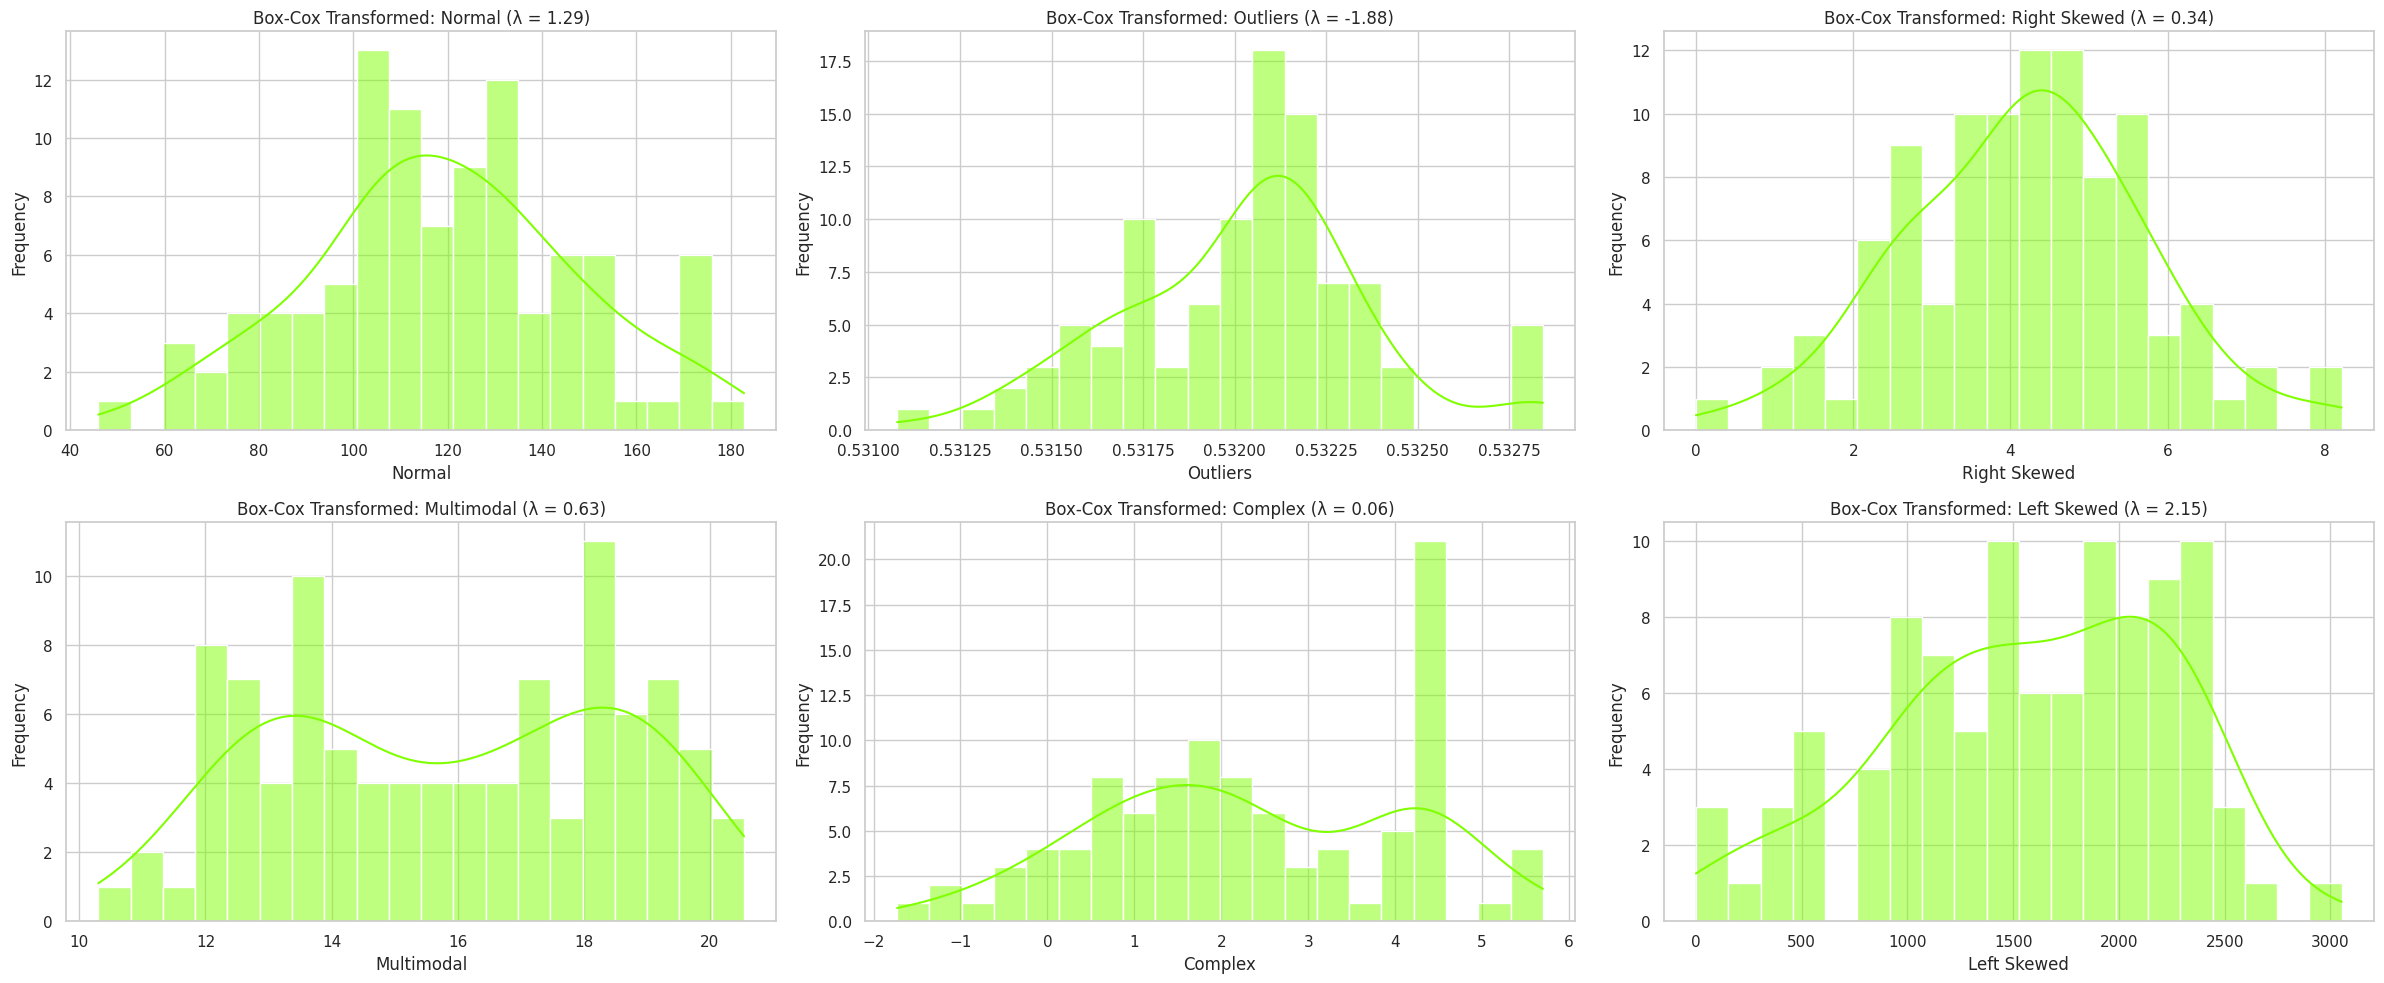

In [ ]:
boxcox_transformed = {}
lmbda_values = {}

for feature in features:
    shifted_data = data[feature] - data[feature].min() + 1 if data[feature].min() <= 0 else data[feature]
    transformed, lmbda = stats.boxcox(shifted_data)
    boxcox_transformed[feature] = transformed
    lmbda_values[feature] = lmbda

boxcox_df = pd.DataFrame(boxcox_transformed)

fig, axes = plt.subplots(2, 3, figsize=(24, 10))
for i, feature in enumerate(features):
    ax = axes.flat[i]
    sns.histplot(boxcox_df[feature], kde=True, bins=20, ax=ax, alpha=0.5, color="#7fff00")
    ax.set_title(f"Box-Cox Transformed: {feature} (λ = {lmbda_values[feature]:.2f})")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


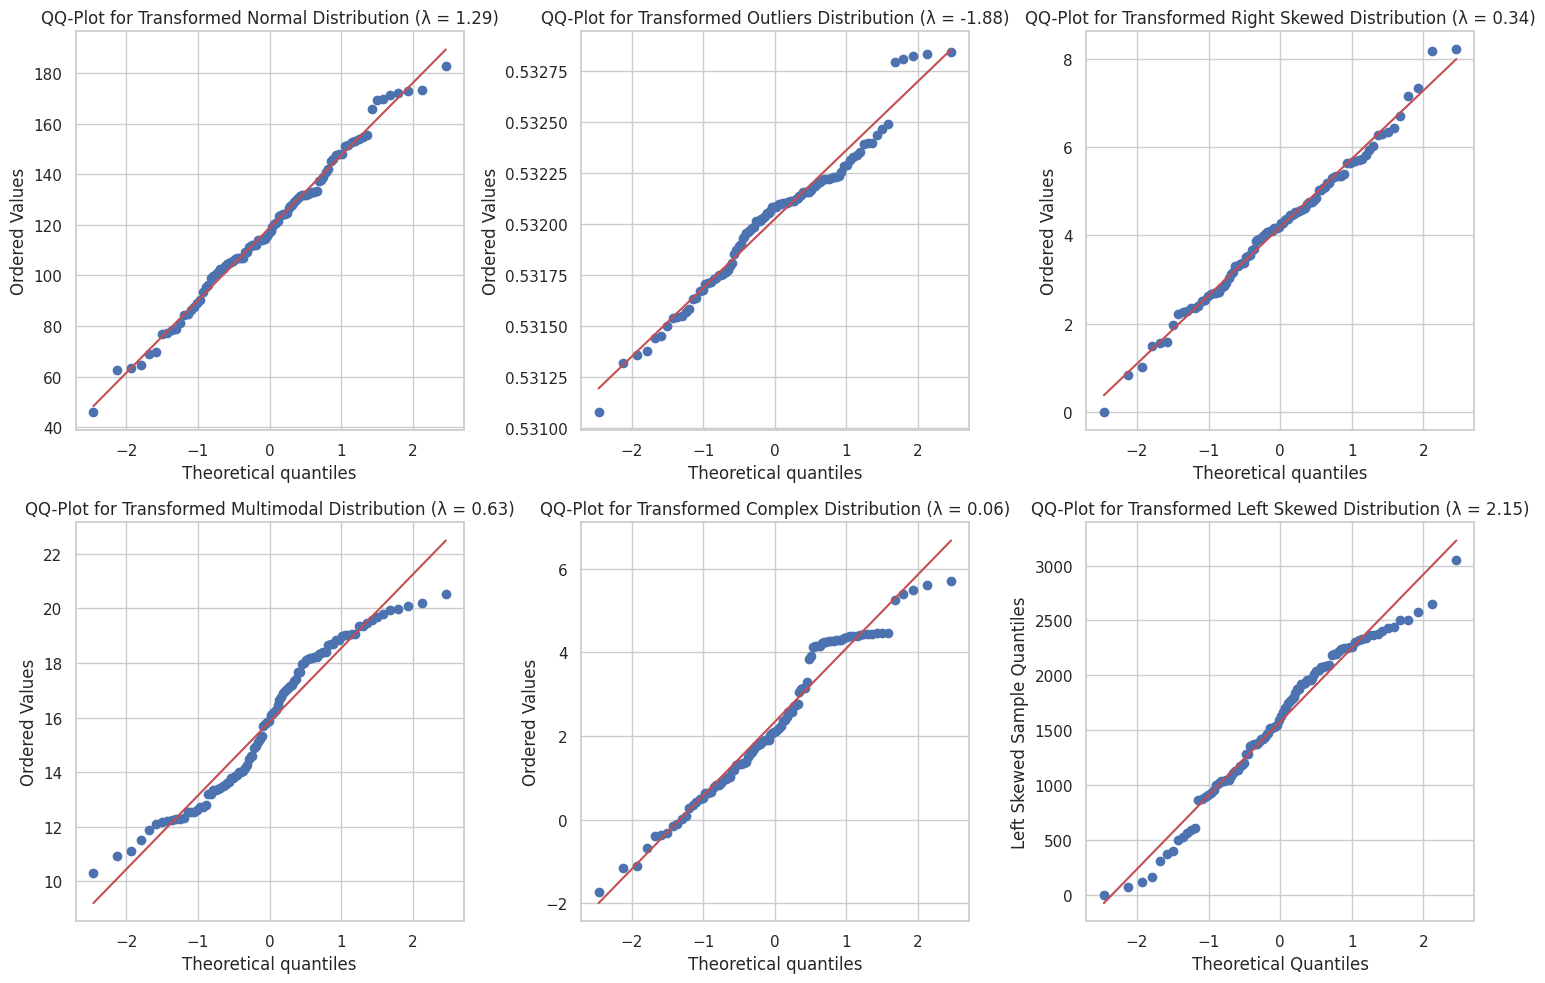

In [ ]:
import statsmodels.api as sm

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features = ["Normal", "Outliers", "Right Skewed", "Multimodal", "Complex", "Left Skewed"]
for i, feature in enumerate(features):
    ax = axes.flat[i]
    #sm.qqplot(data[feature], line='s', fit=True)
    stats.probplot(boxcox_df[feature], dist="norm", plot=ax, fit=True)
    plt.title("")
    ax.set_title(f"QQ-Plot for Transformed {feature} Distribution (λ = {lmbda_values[feature]:.2f})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel(f"{feature} Sample Quantiles")

plt.tight_layout()
plt.show()

Metrics for Original Features:
Mean Squared Error (MSE): 23.8222
R-squared (R2): 0.0701

Metrics for Transformed Features:
Mean Squared Error (MSE): 23.4395
R-squared (R2): 0.0851

Box-Cox transformed features lead to a lower MSE.
Box-Cox transformed features improve the R-squared value.


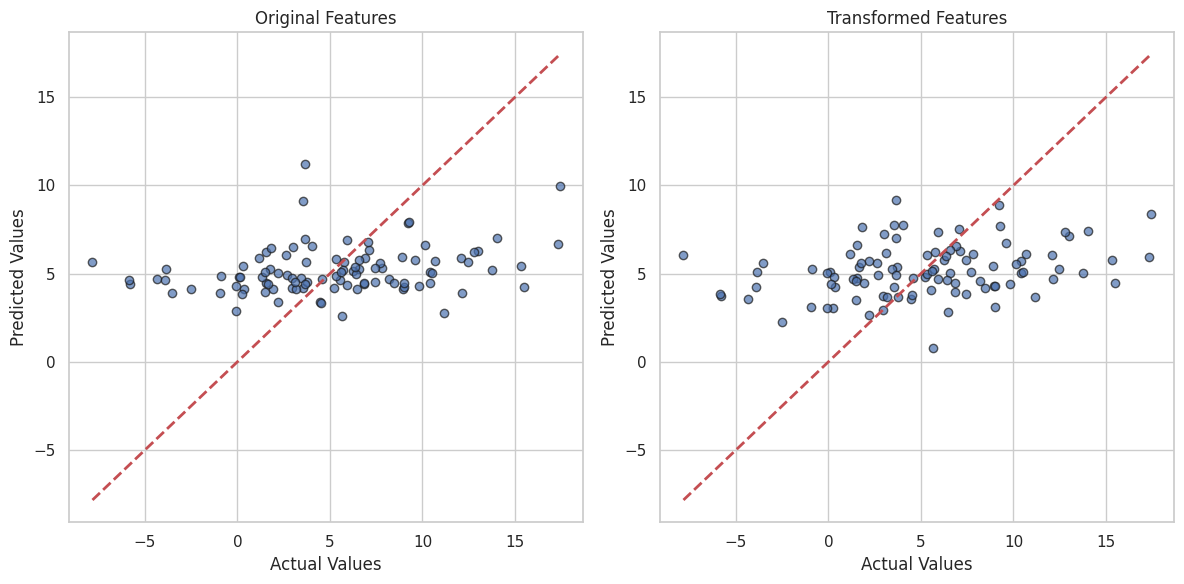

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_original = data[features]
y = data["Response"]

X_transformed = boxcox_df[features]

model_original = LinearRegression().fit(X_original, y)
model_transformed = LinearRegression().fit(X_transformed, y)

y_pred_original = model_original.predict(X_original)
y_pred_transformed = model_transformed.predict(X_transformed)

mse_original = mean_squared_error(y, y_pred_original)
r2_original = r2_score(y, y_pred_original)

mse_transformed = mean_squared_error(y, y_pred_transformed)
r2_transformed = r2_score(y, y_pred_transformed)

mse_original, r2_original, mse_transformed, r2_transformed


print("Metrics for Original Features:")
print(f"Mean Squared Error (MSE): {mse_original:.4f}")
print(f"R-squared (R2): {r2_original:.4f}\n")

print("Metrics for Transformed Features:")
print(f"Mean Squared Error (MSE): {mse_transformed:.4f}")
print(f"R-squared (R2): {r2_transformed:.4f}\n")

if mse_transformed < mse_original:
    print("Box-Cox transformed features lead to a lower MSE.")
else:
    print("Original features lead to a lower MSE.")

if r2_transformed > r2_original:
    print("Box-Cox transformed features improve the R-squared value.")
else:
    print("Original features provide a better R-squared value.")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_original, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Original Features")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_transformed, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Transformed Features")
plt.grid(True)

plt.tight_layout()
plt.show()


Метрики для оригинальных данных:
MSE: 22.4340, R2: 0.8632

Метрики для трансформированных данных:
MSE: 25.8307, R2: 0.8425

Box-Cox трансформация не улучшила MSE.
Box-Cox трансформация не улучшила R2.


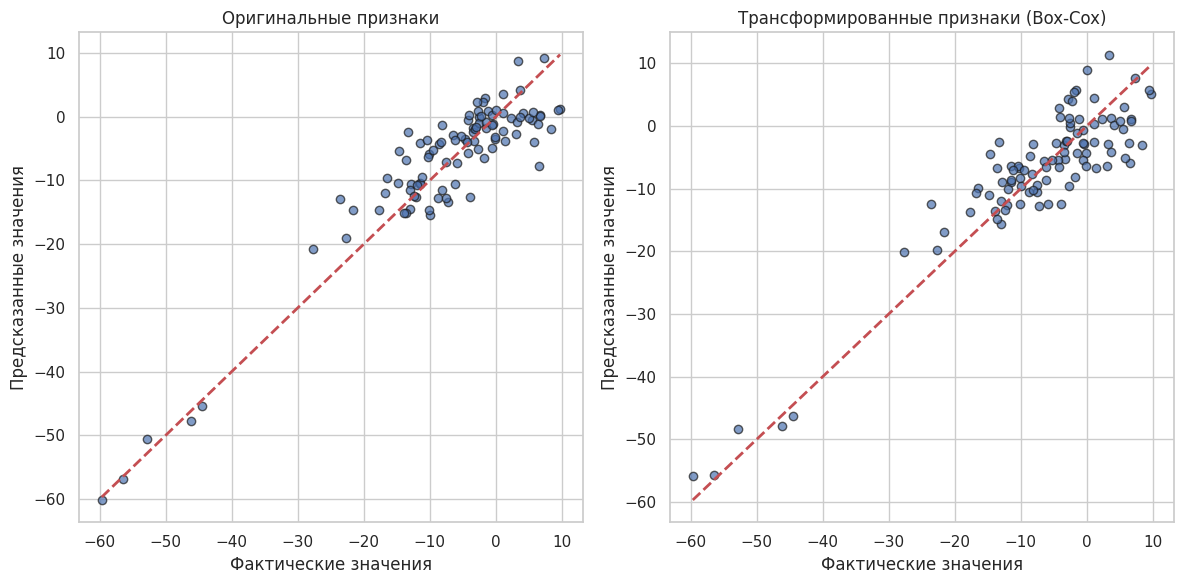

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer

# Метод Бокса-Кокса может применяться только к положительным данным
boxcox_df = data.copy()
for col in ["Skewed", "Complex"]:  # Применяем только к наиболее проблемным колонкам
    boxcox_df[col], _ = boxcox(data[col] + 1e-6)  # Добавляем небольшое значение, чтобы избежать 0

features = ["Normal", "Outliers", "Skewed", "Multimodal", "Complex"]
X_original = data[features]
y = data["Response"]

X_transformed = boxcox_df[features]

model_original = LinearRegression().fit(X_original, y)
model_transformed = LinearRegression().fit(X_transformed, y)

y_pred_original = model_original.predict(X_original)
y_pred_transformed = model_transformed.predict(X_transformed)

mse_original = mean_squared_error(y, y_pred_original)
r2_original = r2_score(y, y_pred_original)

mse_transformed = mean_squared_error(y, y_pred_transformed)
r2_transformed = r2_score(y, y_pred_transformed)

print("Метрики для оригинальных данных:")
print(f"MSE: {mse_original:.4f}, R2: {r2_original:.4f}")

print("\nМетрики для трансформированных данных:")
print(f"MSE: {mse_transformed:.4f}, R2: {r2_transformed:.4f}")

if mse_transformed < mse_original:
    print("\nBox-Cox трансформация улучшила MSE.")
else:
    print("\nBox-Cox трансформация не улучшила MSE.")

if r2_transformed > r2_original:
    print("Box-Cox трансформация улучшила R2.")
else:
    print("Box-Cox трансформация не улучшила R2.")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred_original, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Оригинальные признаки")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y, y_pred_transformed, alpha=0.7, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.title("Трансформированные признаки (Box-Cox)")
plt.grid(True)

plt.tight_layout()
plt.show()